【dataset】<br>
/export/data/dataset/UECFOOD/BB/UECFOOD100　<br>
/export/data/dataset/UECFOOD/BB/UECFOOD256 <br>
/export/data/dataset/food101 <br>

【model】<br>
fine-turing from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html <br>
//Yanai lab or general code?? https://github.com/Prakhar998/food-101 skip<br>
SOTA in Survey(reproduced) https://github.com/aurotripathy/food-classify <br>


### fine-tuning on VGG16 on UECFOOD100

In [2]:
from __future__ import print_function
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1
Torchvision Version:  0.6.0a0+35d732a


In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./UECFOOD100"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg16"

# Number of classes in the dataset
num_classes = 100

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
model_ft = models.vgg16_bn(pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/yanai-lab/yamamoto-k/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
#dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [12]:
dataset=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['val']) 
dataset2=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

num = len(dataset)
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)
image_datasets = {'train': trainset,
                                  'val': testset,}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [13]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 4.1285 Acc: 0.1193
val Loss: 3.5263 Acc: 0.2207

Epoch 1/31
----------
train Loss: 3.4682 Acc: 0.2534
val Loss: 2.9722 Acc: 0.3676

Epoch 2/31
----------
train Loss: 3.0962 Acc: 0.3321
val Loss: 2.6234 Acc: 0.4361

Epoch 3/31
----------
train Loss: 2.8471 Acc: 0.3751
val Loss: 2.4096 Acc: 0.4727

Epoch 4/31
----------
train Loss: 2.6688 Acc: 0.4025
val Loss: 2.2150 Acc: 0.5040

Epoch 5/31
----------
train Loss: 2.5422 Acc: 0.4220
val Loss: 2.1157 Acc: 0.5137

Epoch 6/31
----------
train Loss: 2.4356 Acc: 0.4443
val Loss: 2.0013 Acc: 0.5364

Epoch 7/31
----------
train Loss: 2.3483 Acc: 0.4546
val Loss: 1.9237 Acc: 0.5451

Epoch 8/31
----------
train Loss: 2.3051 Acc: 0.4591
val Loss: 1.8721 Acc: 0.5444

Epoch 9/31
----------
train Loss: 2.2507 Acc: 0.4632
val Loss: 1.8025 Acc: 0.5663

Epoch 10/31
----------
train Loss: 2.2105 Acc: 0.4658
val Loss: 1.7729 Acc: 0.5667

Epoch 11/31
----------
train Loss: 2.1693 Acc: 0.4794
val Loss: 1.7407 Acc: 0.5726

Ep

In [17]:
# モデルを保存する。
torch.save(model_ft.state_dict(),"./model_save/Classification_VGG16_UECFOOD100_1.pth")

# 保存したモデルを読み込む。
#model.load_state_dict(torch.load("model.pth"))

In [18]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 1.8401 Acc: 0.5292
val Loss: 1.4520 Acc: 0.6123

Epoch 1/31
----------
train Loss: 1.8339 Acc: 0.5307
val Loss: 1.4420 Acc: 0.6223

Epoch 2/31
----------
train Loss: 1.8482 Acc: 0.5272
val Loss: 1.4344 Acc: 0.6234

Epoch 3/31
----------
train Loss: 1.8251 Acc: 0.5338
val Loss: 1.4385 Acc: 0.6171

Epoch 4/31
----------
train Loss: 1.8338 Acc: 0.5344
val Loss: 1.4522 Acc: 0.6136

Epoch 5/31
----------
train Loss: 1.8519 Acc: 0.5249
val Loss: 1.4192 Acc: 0.6237

Epoch 6/31
----------
train Loss: 1.7969 Acc: 0.5382
val Loss: 1.4113 Acc: 0.6223

Epoch 7/31
----------
train Loss: 1.8068 Acc: 0.5358
val Loss: 1.4170 Acc: 0.6255

Epoch 8/31
----------
train Loss: 1.7931 Acc: 0.5353
val Loss: 1.4189 Acc: 0.6227

Epoch 9/31
----------
train Loss: 1.8263 Acc: 0.5275
val Loss: 1.4093 Acc: 0.6248

Epoch 10/31
----------
train Loss: 1.7850 Acc: 0.5424
val Loss: 1.4140 Acc: 0.6227

Epoch 11/31
----------
train Loss: 1.7981 Acc: 0.5375
val Loss: 1.4054 Acc: 0.6244

Ep

In [19]:
torch.save(model_ft.state_dict(),"./model_save/Classification_VGG16_UECFOOD100_2.pth")

### fine-tuning on VGG16 on UECFOOD256

In [20]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./UECFOOD256"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg16"

# Number of classes in the dataset
num_classes = 256

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [21]:
model_ft = models.vgg16_bn(pretrained=True)
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)


dataset=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['val']) 
dataset2=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

num = len(dataset)
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)
image_datasets = {'train': trainset,
                                  'val': testset,}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [22]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 5.1264 Acc: 0.0641
val Loss: 4.5408 Acc: 0.1653

Epoch 1/31
----------
train Loss: 4.4582 Acc: 0.1627
val Loss: 3.9259 Acc: 0.2702

Epoch 2/31
----------
train Loss: 4.0106 Acc: 0.2304
val Loss: 3.5179 Acc: 0.3258

Epoch 3/31
----------
train Loss: 3.7100 Acc: 0.2719
val Loss: 3.2227 Acc: 0.3623

Epoch 4/31
----------
train Loss: 3.4856 Acc: 0.3029
val Loss: 3.0232 Acc: 0.3872

Epoch 5/31
----------
train Loss: 3.3116 Acc: 0.3259
val Loss: 2.8441 Acc: 0.4084

Epoch 6/31
----------
train Loss: 3.1864 Acc: 0.3373
val Loss: 2.7234 Acc: 0.4231

Epoch 7/31
----------
train Loss: 3.0701 Acc: 0.3560
val Loss: 2.6276 Acc: 0.4263

Epoch 8/31
----------
train Loss: 2.9945 Acc: 0.3603
val Loss: 2.5480 Acc: 0.4381

Epoch 9/31
----------
train Loss: 2.9105 Acc: 0.3714
val Loss: 2.4696 Acc: 0.4480

Epoch 10/31
----------
train Loss: 2.8479 Acc: 0.3800
val Loss: 2.4197 Acc: 0.4528

Epoch 11/31
----------
train Loss: 2.8075 Acc: 0.3826
val Loss: 2.3585 Acc: 0.4668

Ep

In [23]:
torch.save(model_ft.state_dict(),"./model_save/Classification_VGG16_UECFOOD256_1.pth")

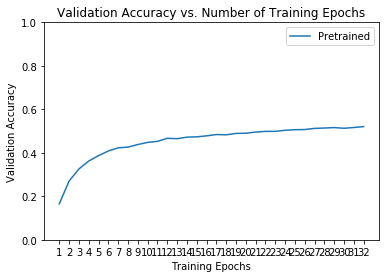

In [24]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [29]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 2.3657 Acc: 0.4419
val Loss: 1.9680 Acc: 0.5180

Epoch 1/31
----------
train Loss: 2.3520 Acc: 0.4439
val Loss: 1.9578 Acc: 0.5232

Epoch 2/31
----------
train Loss: 2.3477 Acc: 0.4446
val Loss: 1.9679 Acc: 0.5180

Epoch 3/31
----------
train Loss: 2.3383 Acc: 0.4429
val Loss: 1.9584 Acc: 0.5226

Epoch 4/31
----------
train Loss: 2.3267 Acc: 0.4457
val Loss: 1.9499 Acc: 0.5233

Epoch 5/31
----------
train Loss: 2.3211 Acc: 0.4493
val Loss: 1.9346 Acc: 0.5256

Epoch 6/31
----------
train Loss: 2.3015 Acc: 0.4561
val Loss: 1.9444 Acc: 0.5210

Epoch 7/31
----------
train Loss: 2.3128 Acc: 0.4471
val Loss: 1.9389 Acc: 0.5251

Epoch 8/31
----------
train Loss: 2.2676 Acc: 0.4586
val Loss: 1.9181 Acc: 0.5311

Epoch 9/31
----------
train Loss: 2.2868 Acc: 0.4576
val Loss: 1.9145 Acc: 0.5327

Epoch 10/31
----------
train Loss: 2.2701 Acc: 0.4587
val Loss: 1.9141 Acc: 0.5320

Epoch 11/31
----------
train Loss: 2.2765 Acc: 0.4531
val Loss: 1.9073 Acc: 0.5304

Ep

In [30]:
torch.save(model_ft.state_dict(),"./model_save/Classification_VGG16_UECFOOD256_2.pth")

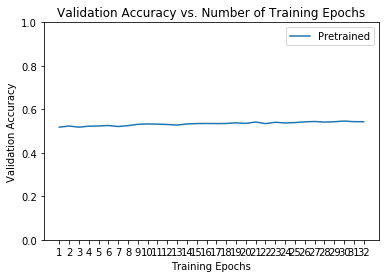

In [31]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### fine-tuning on VGG16 on FOOD101

In [32]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./food101/images"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg16"

# Number of classes in the dataset
num_classes = 101

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [33]:
model_ft = models.vgg16_bn(pretrained=True)
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)


dataset=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['val']) 
dataset2=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

num = len(dataset)
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)
image_datasets = {'train': trainset,
                                  'val': testset,}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [34]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 3.3486 Acc: 0.2869
val Loss: 2.4064 Acc: 0.4617

Epoch 1/31
----------
train Loss: 2.6384 Acc: 0.3861
val Loss: 2.1262 Acc: 0.4941

Epoch 2/31
----------
train Loss: 2.4867 Acc: 0.4082
val Loss: 2.0082 Acc: 0.5120

Epoch 3/31
----------
train Loss: 2.4198 Acc: 0.4185
val Loss: 1.9393 Acc: 0.5233

Epoch 4/31
----------
train Loss: 2.3710 Acc: 0.4265
val Loss: 1.9103 Acc: 0.5292

Epoch 5/31
----------
train Loss: 2.3388 Acc: 0.4314
val Loss: 1.8784 Acc: 0.5343

Epoch 6/31
----------
train Loss: 2.3129 Acc: 0.4373
val Loss: 1.8668 Acc: 0.5348

Epoch 7/31
----------
train Loss: 2.2928 Acc: 0.4404
val Loss: 1.8460 Acc: 0.5392

Epoch 8/31
----------
train Loss: 2.2760 Acc: 0.4427
val Loss: 1.8279 Acc: 0.5421

Epoch 9/31
----------
train Loss: 2.2701 Acc: 0.4453
val Loss: 1.8133 Acc: 0.5472

Epoch 10/31
----------
train Loss: 2.2586 Acc: 0.4469
val Loss: 1.8008 Acc: 0.5483

Epoch 11/31
----------
train Loss: 2.2459 Acc: 0.4494
val Loss: 1.8024 Acc: 0.5496

Ep

In [35]:
torch.save(model_ft.state_dict(),"./model_save/Classification_VGG16_food101_1.pth")

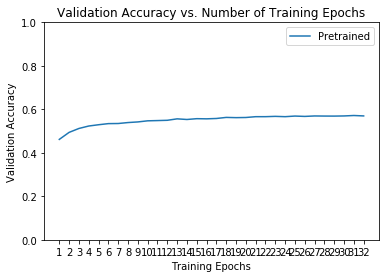

In [36]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### WISeR on UECFOOD100

In [25]:
%pwd

'/host/space0/yamamoto-k/jupyter/notebook/B4-5'

In [26]:
%cd food101
%pwd

/host/data/dataset/food101


'/host/data/dataset/food101'

In [27]:
%cd ..
%pwd

/host/data/dataset


'/host/data/dataset'

In [28]:
%cd /host/space0/yamamoto-k/jupyter/notebook/B4-5
%pwd

/host/space0/yamamoto-k/jupyter/notebook/B4-5


'/host/space0/yamamoto-k/jupyter/notebook/B4-5'

In [ ]:
%python build_dataset.py --root-folder food101

In [ ]:
%python3 train_validate.py --batch-size 64 --epochs 32 --train-data food-101/train_val_test/

In [ ]:
%python3 test_model.py --model-file ./trained_models/checkpoint.pth --test-data /media/auro/RAID5/food-101/food-101/train_val_test/

In [70]:
drop_prob = 0.5

class SliceBranch(torch.nn.Module):
    """ Describe slice branch from the paper """ 
    def __init__(self, input_size, output_size):
        super(SliceBranch, self).__init__()
        kernel_size = (224, 5)  # 
        self.wide_conv = torch.nn.Conv2d(input_size,
                                    output_size,
                                    kernel_size,
                                    stride=1,
                                    padding=0,
                                    bias=True)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.maxpool = torch.nn.MaxPool2d((1, 5))
        
    def forward(self, x):
        out1 = nn.functional.relu(self.bn(self.wide_conv(x)))
        out2 = self.maxpool(out1)
        out3 = self.maxpool(out2)
        out4 = self.maxpool(out3)
        
        return out4

class WideResnet101PlusSlice(torch.nn.Module):
  def __init__(self, nb_classes, drop_prob):
    super(WideResnet101PlusSlice, self).__init__()
    self.slice_branch = SliceBranch(3, 320)
    self.wide_res101_pretrained = models.wide_resnet101_2(pretrained=True)
    
    #add
    set_parameter_requires_grad(self.wide_res101_pretrained, True)
    
    self.res101_branch = torch.nn.Sequential(*list(self.wide_res101_pretrained.children())[:-1])

    self.fc1 = torch.nn.Linear(2368, 2048)
    self.dropout = nn.Dropout(p=drop_prob)
    self.fc2 = torch.nn.Linear(2048, nb_classes)  

  def forward(self, x):
    s_b = self.slice_branch(x)
    #print(s_b.size())
    r_b = self.res101_branch(x)
    #print(r_b.size())
    out = torch.cat([s_b, r_b], dim=1)    
    out = torch.flatten(out, 1)
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [71]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./UECFOOD100"

# Number of classes in the dataset
num_classes = 100

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [72]:
model_ft = WideResnet101PlusSlice(num_classes, drop_prob)
print(model_ft)

WideResnet101PlusSlice(
  (slice_branch): SliceBranch(
    (wide_conv): Conv2d(3, 320, kernel_size=(224, 5), stride=(1, 1))
    (bn): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
  )
  (wide_res101_pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchN

In [73]:
input_size= 224

In [74]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
#dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [75]:
#model_ft = models.vgg16_bn(pretrained=True)
# Initialize the model for this run
#model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)


dataset=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['val']) 
dataset2=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

num = len(dataset)
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)
image_datasets = {'train': trainset,
                                  'val': testset,}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

cuda:0
Params to learn:
	 slice_branch.wide_conv.weight
	 slice_branch.wide_conv.bias
	 slice_branch.bn.weight
	 slice_branch.bn.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


In [76]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 4.1477 Acc: 0.1146
val Loss: 3.7373 Acc: 0.1967

Epoch 1/31
----------
train Loss: 3.5977 Acc: 0.2063
val Loss: 3.2517 Acc: 0.2743

Epoch 2/31
----------
train Loss: 3.2398 Acc: 0.2671
val Loss: 2.9022 Acc: 0.3380

Epoch 3/31
----------
train Loss: 2.9679 Acc: 0.3214
val Loss: 2.5950 Acc: 0.4062

Epoch 4/31
----------
train Loss: 2.7291 Acc: 0.3686
val Loss: 2.3234 Acc: 0.4803

Epoch 5/31
----------
train Loss: 2.5538 Acc: 0.4070
val Loss: 2.1429 Acc: 0.4995

Epoch 6/31
----------
train Loss: 2.4043 Acc: 0.4331
val Loss: 2.0148 Acc: 0.5294

Epoch 7/31
----------
train Loss: 2.2784 Acc: 0.4570
val Loss: 1.9022 Acc: 0.5412

Epoch 8/31
----------
train Loss: 2.1869 Acc: 0.4701
val Loss: 1.7990 Acc: 0.5614

Epoch 9/31
----------
train Loss: 2.1077 Acc: 0.4815
val Loss: 1.7308 Acc: 0.5708

Epoch 10/31
----------
train Loss: 2.0483 Acc: 0.4961
val Loss: 1.6555 Acc: 0.5889

Epoch 11/31
----------
train Loss: 1.9878 Acc: 0.4987
val Loss: 1.5979 Acc: 0.6029

Ep

In [77]:
torch.save(model_ft.state_dict(),"./model_save/Classification_WISeR_UECFOOD100_1.pth")

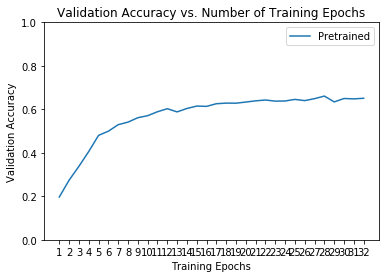

In [78]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### WISeR on UECFOOD256

In [79]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./UECFOOD256"

# Number of classes in the dataset
num_classes = 256

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [80]:
model_ft = WideResnet101PlusSlice(num_classes, drop_prob)
#model_ft = models.vgg16_bn(pretrained=True)
# Initialize the model for this run
#model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)


dataset=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['val']) 
dataset2=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

num = len(dataset)
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)
image_datasets = {'train': trainset,
                                  'val': testset,}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

cuda:0
Params to learn:
	 slice_branch.wide_conv.weight
	 slice_branch.wide_conv.bias
	 slice_branch.bn.weight
	 slice_branch.bn.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


In [81]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 5.1701 Acc: 0.0548
val Loss: 4.7590 Acc: 0.0937

Epoch 1/31
----------
train Loss: 4.5562 Acc: 0.1148
val Loss: 4.1872 Acc: 0.1812

Epoch 2/31
----------
train Loss: 4.1076 Acc: 0.1712
val Loss: 3.7403 Acc: 0.2435

Epoch 3/31
----------
train Loss: 3.7486 Acc: 0.2244
val Loss: 3.3629 Acc: 0.3036

Epoch 4/31
----------
train Loss: 3.4605 Acc: 0.2630
val Loss: 3.0808 Acc: 0.3368

Epoch 5/31
----------
train Loss: 3.2376 Acc: 0.2939
val Loss: 2.8312 Acc: 0.3768

Epoch 6/31
----------
train Loss: 3.0637 Acc: 0.3213
val Loss: 2.6474 Acc: 0.4022

Epoch 7/31
----------
train Loss: 2.9246 Acc: 0.3454
val Loss: 2.5186 Acc: 0.4199

Epoch 8/31
----------
train Loss: 2.7913 Acc: 0.3673
val Loss: 2.3995 Acc: 0.4397

Epoch 9/31
----------
train Loss: 2.7157 Acc: 0.3757
val Loss: 2.3566 Acc: 0.4422

Epoch 10/31
----------
train Loss: 2.6364 Acc: 0.3904
val Loss: 2.2627 Acc: 0.4607

Epoch 11/31
----------
train Loss: 2.5744 Acc: 0.4027
val Loss: 2.1804 Acc: 0.4783

Ep

In [82]:
torch.save(model_ft.state_dict(),"./model_save/Classification_WISeR_UECFOOD256_1.pth")

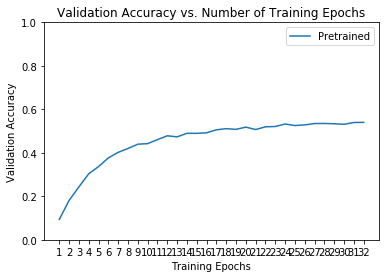

In [83]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### WISeR on FOOD101

In [84]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./food101/images"

# Number of classes in the dataset
num_classes = 101

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [85]:
model_ft = WideResnet101PlusSlice(num_classes, drop_prob)
#model_ft = models.vgg16_bn(pretrained=True)
# Initialize the model for this run
#model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)


dataset=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['val']) 
dataset2=torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

num = len(dataset)
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)
image_datasets = {'train': trainset,
                                  'val': testset,}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

cuda:0
Params to learn:
	 slice_branch.wide_conv.weight
	 slice_branch.wide_conv.bias
	 slice_branch.bn.weight
	 slice_branch.bn.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


In [86]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/31
----------
train Loss: 3.6682 Acc: 0.2036
val Loss: 2.6227 Acc: 0.4110

Epoch 1/31
----------
train Loss: 2.6852 Acc: 0.3697
val Loss: 2.1331 Acc: 0.4859

Epoch 2/31
----------
train Loss: 2.4207 Acc: 0.4151
val Loss: 1.9932 Acc: 0.5064

Epoch 3/31
----------
train Loss: 2.3127 Acc: 0.4358
val Loss: 1.9219 Acc: 0.5161

Epoch 4/31
----------
train Loss: 2.2457 Acc: 0.4516
val Loss: 1.8553 Acc: 0.5323

Epoch 5/31
----------
train Loss: 2.1999 Acc: 0.4599
val Loss: 1.8201 Acc: 0.5428

Epoch 6/31
----------
train Loss: 2.1671 Acc: 0.4695
val Loss: 1.8011 Acc: 0.5471

Epoch 7/31
----------
train Loss: 2.1443 Acc: 0.4752
val Loss: 1.7780 Acc: 0.5537

Epoch 8/31
----------
train Loss: 2.1305 Acc: 0.4763
val Loss: 1.7551 Acc: 0.5552

Epoch 9/31
----------
train Loss: 2.1075 Acc: 0.4818
val Loss: 1.7411 Acc: 0.5627

Epoch 10/31
----------
train Loss: 2.0890 Acc: 0.4851
val Loss: 1.7231 Acc: 0.5668

Epoch 11/31
----------
train Loss: 2.0750 Acc: 0.4877
val Loss: 1.7377 Acc: 0.5606

Ep

In [87]:
torch.save(model_ft.state_dict(),"./model_save/Classification_WISeR_FOOD101_1.pth")

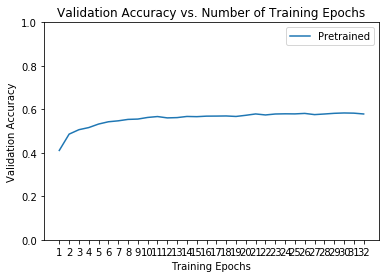

In [88]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()